### Create geometry

In [1]:
import time
start_time = time.time()

In [2]:

# To run on jupyter
patient_number       = "demo"
N                    = 250 # 3 #
obtain_training_data = "compute_points" #
nIter                = 300 # 2 #
criterion_bo         = "EI" # "LCB" # "LW-LCB"
optimization_points  =   "run_opt" # "load_opt_points"

In [3]:
print ( "#####################################")
print (f"Running analysis of patient {patient_number}")
print (f"N = {N}, {obtain_training_data}            ") 
print (f"nIter = {nIter}, {optimization_points}  ")
print ( "#####################################")

#####################################
Running analysis of patient demo
N = 250, compute_points            
nIter = 300, run_opt  
#####################################


In [4]:
from bo_purkinje_demo import BO_Purkinje
from myocardial_mesh import MyocardialMesh

Import of Cupy failed. The GPU version of fimpy will be unavailable. Message: No module named 'cupy'


In [5]:
from bo_ecg import BO_ecg

In [6]:
import numpy as onp
import jax.numpy as np
import jax
jax.config.update("jax_enable_x64", True)

from jax import random, lax
from jaxbo.models import GP
from jaxbo.utils import normalize

import matplotlib.pyplot as plt
import os
import shutil
import pickle
import pandas as pd
import seaborn as sns

from jax import ops
from scipy.stats import norm

onp.random.seed(1234)

### Create reference tree

In [7]:
if patient_number == "demo":
    patient = "PurkinjeECG/data/crtdemo/crtdemo"
#     qrs_in, qrs_fin = 200, 400
    meshes_list_pat = [388, 412, 198, 186] # These are node indices (of the LV and RV endocardial meshes) that determine the direction of the
                                           # initial branch of the Purkinje Tree
                                           # Here, 388 and 412 are nodes of the LV endocardial mesh and
                                           #       198 and 186 are nodes of the RV endocardial mesh
    myo = MyocardialMesh(myo_mesh            = f"{patient}_mesh_oriented.vtk",
                    electrodes_position = f"PurkinjeECG/data/crtdemo/electrode_pos.pkl",
                    fibers              = f"{patient}_f0_oriented.vtk",
                    device = 'cpu') # or 'gpu' is available

else:
    raise Exception("patient_number must be 'demo'")

Conduction velocity in the direction of the fibers: 0.8660254037844386 m/s
assembling Laplacian
initializing FIM solver
0.2180635929107666


In [8]:
# Demo
true_parameters_values = {"patient"         : patient,
                          "meshes_list"     : meshes_list_pat, 
                          "init_length"     : 0., 
                          "length"          : 8.,
                          "w"               : 0.1, 
                          "l_segment"       : 1.,
                          "fascicles_length": 0., 
                          "fascicles_angles": 0., 
                          "branch_angle"    : 0.15,
                          "N_it"            : 20,
                          "myocardium"      : myo}

Tree_true      = BO_Purkinje(**true_parameters_values)
bo_method_true = BO_ecg(bo_purkinje_tree = Tree_true)

if not os.path.exists("./output/patient"+str(patient_number)):
    os.makedirs("./output/patient"+str(patient_number))

computing uv map
computing uv map


In [9]:
print ("Reading results of patient 1 ...")
if patient_number == "demo":
    X_read = onp.load("PurkinjeECG/output/patient1/data_X_N_250_nIter_300_criterionEI_init_length_fascicles_length_fascicles_angles_root_time_cv.npy")

    y_read = onp.load("PurkinjeECG/output/patient1/data_y_N_250_nIter_300_criterionEI_init_length_fascicles_length_fascicles_angles_root_time_cv.npy")
    
    X_min = X_read[onp.argmin(y_read)]
    y_min = onp.min(y_read)
    

var_params_true = {"init_length"     : [X_min[0], X_min[1]],
                   "fascicles_length": [[0.5*X_min[2], 0.5*X_min[3]],
                                        [0.5*X_min[4], 0.5*X_min[5]]],
                   "fascicles_angles": [[0.1*X_min[6], 0.1*X_min[7]],
                                        [0.1*X_min[8], 0.1*X_min[9]]],
                   "root_time"       : X_min[10],
                   "cv"              : X_min[11]}



print ("Ground truth")
print (f"X_ground_truth: {var_params_true}")

Reading results of patient 1 ...
Ground truth
X_ground_truth: {'init_length': [np.float64(35.931537038275316), np.float64(79.86354832236707)], 'fascicles_length': [[np.float64(4.711579058738858), np.float64(9.129484609771032)], [np.float64(21.703867933650002), np.float64(5.79561866201451)]], 'fascicles_angles': [[np.float64(0.14448952070696136), np.float64(0.23561944901923448)], [np.float64(0.23561944901923448), np.float64(0.23561944901923448)]], 'root_time': np.float64(-75.0), 'cv': np.float64(2.0)}


In [10]:
ecg_true, LVtree_true, RVtree_true = bo_method_true.bo_purkinje_tree.run_ECG(n_sim=0, modify=True, side='both', **var_params_true)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.02386021614074707
solving
2.471193552017212
Iteration 0, nLV = 74, nRV = 0
computing closest nodes to PMJs
0.027556896209716797
solving
1.494978904724121
Iteration 1, nLV = 71, nRV = 0
ECG error = 0.0


In [11]:
# Save true trees and endo
file_name = f"./output/patient{patient_number}/"

pickle.dump(ecg_true, open(f"./output/patient{patient_number}/True_ecg","wb"))
myo.save_pv(file_name+"True_endo.vtu")
LVtree_true.save(file_name+"True_LVtree.vtu")
RVtree_true.save(file_name+"True_RVtree.vtu")

In [12]:
qrs_in, qrs_fin = 0, len (ecg_true) # in this case we will use the full ecgs
ecg_pat_array = ecg_true[qrs_in:qrs_fin]

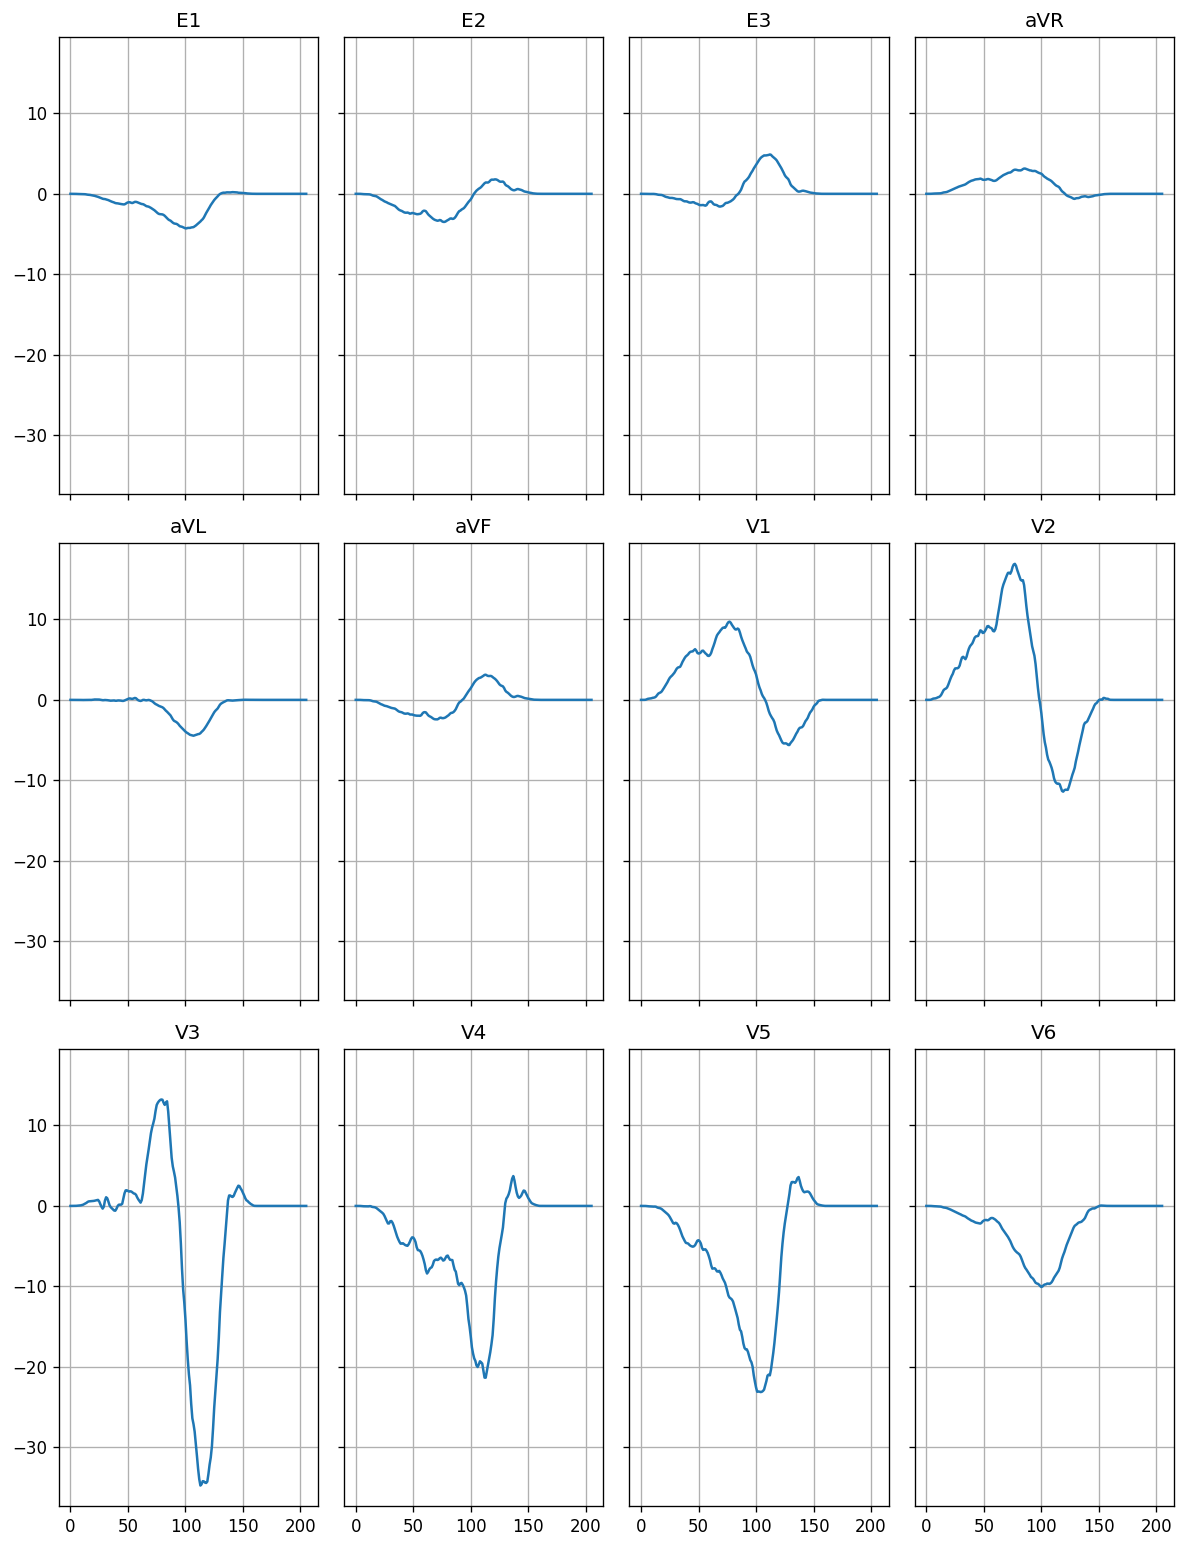

In [13]:
plot_reference_ecg = True

if plot_reference_ecg:
    fig,axs = plt.subplots(3, 4, figsize=(10,13), dpi=120, sharex=True, sharey=True)
    for ax,l in zip(axs.ravel(),ecg_pat_array.dtype.names):
        ax.plot(ecg_pat_array[l])
        ax.grid()
        ax.set_title(l)
    #     ax.legend()
    fig.tight_layout()
    plt.show()

In [14]:
# NOTE: In bo_ecg.calculate_loss(), cut_fin = 0, as here we compare the full ecgs.

### Bayesian optimization (with jaxbo)

In [ ]:
dim = 2

def var_parameters_dict(var_parameters_names):
    # Parameters to find
    var_parameters = {}
    
    # init_length
    if "init_length" in var_parameters_names:
        lb_init_length                = 30.0 * onp.ones(dim)
        ub_init_length                = 100.0 * onp.ones(dim)
        var_parameters["init_length"] = [lb_init_length, ub_init_length, "uniform"]

    # length
    if "length" in var_parameters_names:
        lb_length                = 4. * onp.ones(1)
        ub_length                = 12. * onp.ones(1)
        var_parameters["length"] = [lb_length, ub_length, "uniform"]

    # w
    if "w" in var_parameters_names:
        lb_w                = 0.05* onp.ones(1) # 0.05
        ub_w                = 0.25 * onp.ones(1) # 0.8
        var_parameters["w"] = [lb_w, ub_w, "uniform"]

    # l_segment
    if "l_segment" in var_parameters_names:
        lb_l_segment                = 1. * onp.ones(dim)
        ub_l_segment                = 15. * onp.ones(dim)
        var_parameters["l_segment"] = [lb_l_segment, ub_l_segment, "uniform"]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        lb_fascicles_length                = 2.0 * onp.ones(2*dim) # 10 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_length                = 50.0 * onp.ones(2*dim) # 30
        var_parameters["fascicles_length"] = [lb_fascicles_length, ub_fascicles_length, "uniform"]

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        lb_fascicles_angles                = -1./4. * onp.pi * np.ones(2*dim) # 0.1 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_angles                =  3./4. * onp.pi * np.ones(2*dim) # 1.57
        var_parameters["fascicles_angles"] = [lb_fascicles_angles, ub_fascicles_angles, "uniform"]

    # branch_angle
    if "branch_angle" in var_parameters_names:
        lb_branch_angle                = 5. * onp.pi/180. * np.ones(1)
        ub_branch_angle                = 45. * onp.pi/180. * np.ones(1)
        var_parameters["branch_angle"] = [lb_branch_angle, ub_branch_angle, "uniform"]
    
    # root_time
    if "root_time" in var_parameters_names:
        lb_root_time                = -75. * np.ones(1)
        ub_root_time                = 50. * np.ones(1)
        var_parameters["root_time"] = [lb_root_time, ub_root_time, "uniform"]
        
    # cv
    if "cv" in var_parameters_names:
        lb_cv                = 2. * np.ones(1)
        ub_cv                = 4. * np.ones(1)
        var_parameters["cv"] = [lb_cv, ub_cv, "uniform"]
        
    return var_parameters


def initial_values(var_parameters_names, patient, meshes_list_pat, myocardium):
    # Initial values for known parameters    
    meshes_list  = meshes_list_pat
    init_length  = 30
    length       = 8. # [mm]
    w            = 0.1
    l_segment    = 1.0

    f_len        = [20.0, 20.0] 
    f_angles     = [1., 1.] 

    branch_angle = 0.15 #20. * onp.pi/180. #0.15
    N_it         = 20

    # Assign 1. to the parameters to find
    # init_length
    if "init_length" in var_parameters_names:
        init_length_bo = 1.
    else:
        init_length_bo = init_length 

    # length
    if "length" in var_parameters_names:
        length_bo = 1.
    else:
        length_bo = length # [mm]

    # w
    if "w" in var_parameters_names:
        w_bo = 1.
    else:
        w_bo = w
        
    # l_segment
    if "l_segment" in var_parameters_names:
        l_segment_bo = 1.
    else:
        l_segment_bo = l_segment # [mm]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        f_len_bo = [1., 1.]
    else:
        f_len_bo = f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        f_angles_bo = [1., 1.] 
    else:
        f_angles_bo = f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        branch_angle_bo = 1.
    else:
        branch_angle_bo = branch_angle

    parameters_values = {"patient"         : patient,
                         "meshes_list"     : meshes_list, 
                         "init_length"     : init_length_bo, 
                         "length"          : length_bo, 
                         "w"               : w_bo, 
                         "l_segment"       : l_segment_bo, 
                         "fascicles_length": f_len_bo, 
                         "fascicles_angles": f_angles_bo, 
                         "branch_angle"    : branch_angle_bo, 
                         "N_it"            : N_it,
                         "myocardium"      : myocardium}
    
    return parameters_values

In [ ]:
var_parameters_list = ["init_length", "fascicles_length", "fascicles_angles","root_time", "cv"]
# var_parameters_list = ["init_length", "length", "w", "fascicles_length", "fascicles_angles",
#                        "branch_angle", "root_time", "cv"]

#assert var_parameters_list == var_parameters_read, "Variables do not match ground truth variables"

initial_params = initial_values(var_parameters_list, patient, meshes_list_pat, myo)
Tree_bo        = BO_Purkinje(**initial_params)
bo_method      = BO_ecg(bo_purkinje_tree = Tree_bo)

# f is the mse between real (ecg_pat_array) and computed ecg
var_parameters = var_parameters_dict(var_parameters_list)
f, p_x         = bo_method.mse_jaxbo(ground_truth = ecg_pat_array, variable_parameters = var_parameters)

In [ ]:
x = np.array([74.12523435, 62.46094801, 24.19023292, 40.65849346, 32.69169548, 49.33628498,
  1.08097521, -0.73921825,  0.74647183,  1.68333156, 12.50440764,  2.5114008 ])
bo_method.set_dictionary_variables(bo_method.variable_parameters, list(onp.array(x)))

In [ ]:
[float(a) for a in x]

In [ ]:
if obtain_training_data == "compute_points":
    print ("Computing training points ...")
    t_ini_train = time.time()    

    bo_method.y_trees_non_valid = 10.
    noise                       = 0.0
    X, y                        = bo_method.set_initial_training_data(N, noise)

    onp.save("./output/patient"+str(patient_number)+"/data_X_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), X)
    onp.save("./output/patient"+str(patient_number)+"/data_y_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), y)
    onp.save("./output/patient"+str(patient_number)+"/data_noise_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), noise)
    
    t_fin_train = time.time()
    print(f"Train time: {t_fin_train - t_ini_train} s")

elif obtain_training_data == "load_data":
    print ("Loading training points ...")

    X     = np.load("./output/patient"+str(patient_number)+"/data_X_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy") 
    y     = np.load("./output/patient"+str(patient_number)+"/data_y_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
    noise = np.load("./output/patient"+str(patient_number)+"/data_noise_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
        
    bo_method.noise = noise

In [ ]:
# Value for non-valid trees
valid   = y != 10.
y_valid = y[valid]

bo_method.y_trees_non_valid = np.max(y_valid) # trees_non_valid 

mask = np.where(y == 10.)[0] # in saved files, non-valid trees are saved with y = 10.
y    = y.at[mask].set(bo_method.y_trees_non_valid)
print (f"y_trees_non_valid = {bo_method.y_trees_non_valid}")

In [ ]:
if bo_method.dim == 2:
    X_star, XX, YY = bo_method.set_test_data()
else:
    X_star = bo_method.set_test_data()

# Global minimun is known
true_x = list(var_params_true.values())

In [ ]:
raise RuntimeError("STOP HERE")

In [ ]:
# Main Bayesian optimization loop
options = {'kernel'     : 'Matern12', # 'Matern52'
           'criterion'  : criterion_bo, # EI: expected improvement; LW-LCB
           'input_prior': p_x,
           'kappa'      : 2.0,
           'nIter'      : nIter}

if optimization_points == "run_opt":
    print ("Running optimization ...")
    t_ini_opt = time.time()
    
    X, y, info_iterations = bo_method.bo_loop(X, y, X_star, true_x, options)
    # mean_iterations, std_iterations, w_pred_iterations, a_pred_iterations = info_iterations
    
    t_fin_opt = time.time()
    print (f"Optimization time: {t_fin_opt - t_ini_opt} s")
    
    # Save points obtained from optimization
    onp.save(f"./output/patient{patient_number}/data_X_N_{N}_nIter_{nIter}_criterion{criterion_bo}_" + 
             "_".join(list(var_parameters.keys())), X)
    
    onp.save(f"./output/patient{patient_number}/data_y_N_{N}_nIter_{nIter}_criterion{criterion_bo}_" + 
             "_".join(list(var_parameters.keys())), y)    
    
elif optimization_points == "load_opt_points":
    print ("Loading optimization points ...")
    bo_method.nIter = nIter
    
    X = np.load("./output/patient"+str(patient_number)+"/data_X_N_"+str(N)+
                "_nIter_"+str(nIter)+"_criterion"+str(options["criterion"])+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
    
    y = np.load("./output/patient"+str(patient_number)+"/data_y_N_"+str(N)+
                "_nIter_"+str(nIter)+"_criterion"+str(options["criterion"])+"_"+
                "_".join(list(var_parameters.keys()))+".npy")

In [ ]:
# Plots of error
list_variable_params = "_".join(list(var_parameters.keys()))
file_name            = f"./output/patient{patient_number}/BO_N{N}_nIter{nIter}_criterion"+str(options["criterion"])+ f"_variableparams_{list_variable_params}" 

plot_MSE = False

if plot_MSE:
    bo_method.plot_mse(X, y, N, file_name)

In [ ]:
ecg_bo, LVtree_bo, RVtree_bo = bo_method.update_purkinje_tree(X, y, var_parameters)

In [ ]:
idx_best = onp.argmin(y)
best_x   = onp.array(X[idx_best,:])

best_var_parameters = bo_method.set_dictionary_variables(var_parameters = var_parameters,
                                                    x_values       = best_x)

ecg_bo,  LVtree_bo, RVtree_bo = bo_method.bo_purkinje_tree.run_ECG(modify = True, side = 'both', **best_var_parameters)

In [ ]:
plot_best_ecg = True

if plot_best_ecg:
    # Plot the best ecg found by the BO along with the reference ecg
    bo_method.plot_ecg_match(predicted = ecg_bo, filename_match = file_name)

In [ ]:
# Save tree
bo_method.bo_purkinje_tree.myocardium.save_pv(file_name+"_myo.vtu")
LVtree_bo.save(file_name+"_LVtree.vtu")
RVtree_bo.save(file_name+"_RVtree.vtu")

In [ ]:
plot_pairplot_bo = False

if plot_pairplot_bo:
    # Create columns names for pairplot
    df_columns = []
    if "init_length" in var_parameters.keys():
        df_columns += ["In. Length L", "In. Length R"]
        
    if "length" in var_parameters.keys():
        df_columns += ["Length"]
        
    if "w" in var_parameters.keys():
        df_columns += ["w"]
        
    if "fascicles_length" in var_parameters.keys():
        df_columns += ["Fas. Length L1", "Fas. Length L2", "Fas. Length R1", "Fas. Length R2"]
        
    if "fascicles_angles" in var_parameters.keys():
        df_columns += ["Fas. Angle L1", "Fas. Angle L2", "Fas. Angle R1", "Fas. Angle R2"]
        
    if "branch_angle" in var_parameters.keys():
        df_columns += ["Branch Angle"]
        
    if "root_time" in var_parameters.keys():
        df_columns += ["Root time"]
        
    if "cv" in var_parameters.keys():
        df_columns += ["CV"]

    # Create data frame with training + optimization points
    df      = pd.DataFrame(X, columns = df_columns)
    df["y"] = y

    # Discretize the continuous variable into bins
    num_bins       = 5
    bin_labels     = [f'Bin {i}' for i in range(1, num_bins + 1)]
    df['hue_bins'] = pd.cut(df['y'], bins = num_bins, labels = bin_labels)

    # Plot the pairplot with hue as the discretized variable
    sns.pairplot(df, hue='hue_bins')

### Rejection sampling

In [ ]:
def find_std_ybest_ecgs(X, y, qrs_in, qrs_fin, var_parameters, bo_class, ecg_patient):
    print (f"Find MSE_best curve ...")

    # Find L_best and std_best comparing y_best = min(y) with all ecgs
    X_min            = X[np.argmin(y)]
    ecg_min, _, _, _ = bo_class.update_purkinje_tree(np.array([X_min]), 1., var_parameters)
    print (f"X_min = {X_min}")
    print (f"y_min = {np.min(y)}")

    # Compare with ecgs of all times (not with the mean of them, as previously)
    mse_values_best = []
    names           = list(ecg_patient.keys())
    for ecg_ind in np.arange(ecg_patient[names[0]].shape[1]):

        ecg_pat_ind = []
        for items in list(ecg_patient.items()):
            ecg_pat_ind.append(items[1][:,ecg_ind] / 1e3)

        ecg_pat_array_ind = onp.rec.fromarrays(ecg_pat_ind, names=names)
        ecg_pat_array_ind = ecg_pat_array_ind[qrs_in:qrs_fin]

        mse_values_best.append(bo_class.calculate_loss(predicted = ecg_min,
                                                       ecg_pat   = ecg_pat_array_ind))

#     L_best_data   = np.mean(np.array(mse_values_best))
#     std_best_data = np.std(np.array(mse_values_best))
    return mse_values_best

In [ ]:
def train_gp_model(X, y, options, bo_class, X_star_uniform, gp_state = None):
    if gp_state is None:
        print ("Train GP model with valid points...")
        valid = y != bo_class.y_trees_non_valid

        X_valid = X[valid]
        y_valid = y[valid]
        
        print (f"{len(X_valid)} valid points")

        rng_key = random.PRNGKey(0)
        gp_model = GP(options)

        # Fetch normalized training data
        norm_batch, norm_const = normalize(X_valid, y_valid, bo_class.bounds)

        # Train GP model
        t_ini_train = time.time()
        rng_key = random.split(rng_key)[0]
        opt_params = gp_model.train(norm_batch,
                                    rng_key,
                                    num_restarts = 5)
        t_fin_train = time.time()
        print (f"Training time: {t_fin_train - t_ini_train} s")

        kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bo_class.bounds}
        #               'kappa': gp_model.options['kappa'],
        #               'gmm_vars': gmm_vars,
        #               'rng_key': rng_key}
        
        gp_state = [gp_model, [norm_batch, norm_const], kwargs]

    else:
        print ("Re-using gp_model (it is not trained again with the new points X, y)...")
        gp_model               = gp_state[0]
        norm_batch, norm_const = gp_state[1]
        kwargs                 = gp_state[2]
        
    # Compute predicted mean and std
    t_ini_pred = time.time()

    # batches
    n_col = 100
    assert (len(X_star_uniform)/n_col).is_integer(), "Modify n_col"

    reshaped_X      = [X_star_uniform[i:i+n_col] for i in range(0, len(X_star_uniform), n_col)]
    mean_it, std_it = lax.map(lambda x: gp_model.predict(x, **kwargs),np.array(reshaped_X))
    mean_it         = mean_it.reshape((1,-1))[0]
    std_it          = std_it.reshape((1,-1))[0]

    # # full
    # mean_it, std_it = gp_model.predict(X_star_uniform, **kwargs)

    t_fin_pred = time.time()
    print (f"Predicting time: {t_fin_pred - t_ini_pred} s")
    
    # Obtain ys and sigmas of X_star_uniform (test points with uniform sampling)
    ys     = mean_it * norm_const["sigma_y"] + norm_const["mu_y"]
    sigmas = std_it * norm_const["sigma_y"]
    
    # Obtain min values predicted by gp model
    X_min             = X[np.argmin(y)]
    mean_min, std_min = gp_model.predict(X_min[None,:], **kwargs)

    y_gp_best     = mean_min * norm_const["sigma_y"] + norm_const["mu_y"]
    sigma_gp_best = std_min * norm_const["sigma_y"] # should be low
    
    return ys, sigmas, y_gp_best, sigma_gp_best, gp_state

In [ ]:
def rejection_sampling(ys, sigmas, y_gp_best, sigma_gp_best):
    # Rejection sampling, the likelihood is obtained comparing with best point

    max_likelihood = norm.pdf(x     = 0.,
                              loc   = 0.,
                              scale = np.sqrt(sigma_gp_best**2 + np.min(sigmas)**2))

    key        = random.PRNGKey(0) # onp.random.randint(50)
    comparison = random.uniform(key, shape = (ys.shape[0],)) * max_likelihood

    likelihoods = norm.pdf(x     = 0.,
                           loc   = ys - y_gp_best,
                           scale = np.sqrt(sigmas**2 + sigma_gp_best**2))
     
    accepted_samples = likelihoods > comparison    

    print(f"{accepted_samples.sum()} accepted samples")
    return accepted_samples, comparison, likelihoods

In [ ]:
def check_accepted_samples(N_samples, X_star_uniform, y_gp_best, accepted_samples, comparison, likelihoods,
                           var_parameters, bo_class, tol, observed_samples, confirmed_samples, folder_trees):
                           # sigma_gp_best, std_best_data

    X_accepted           = X_star_uniform[accepted_samples]
    comparison_accepted  = comparison[accepted_samples]
    likelihoods_accepted = likelihoods[accepted_samples]
    
    sorted_indices       = np.argsort(-likelihoods_accepted)

    X_accepted           = X_accepted[sorted_indices]
    comparison_accepted  = comparison_accepted[sorted_indices]
    
    X_true_new           = []
    Y_true_new           = [] # true value of X_accepted
    
    if len(confirmed_samples) == 0:
        confirmed_samples["samples_final"]  = []
        confirmed_samples["ecg_final"]      = []
#         confirmed_samples["endo_final"] = []
        confirmed_samples["Tree_final"]     = []
        confirmed_samples["loss_final"]     = []

    print (f"tolerance: {tol}")        
    
    state                = []
    observed_samples_new = []

    X_ind        = 1
    n_candidates = accepted_samples.sum()
    for x_accepted, comp in zip(X_accepted, comparison_accepted):

        print (f"Checking point {X_ind}/{n_candidates}")

        observed = False
        for obs_elem in observed_samples:
            if np.array_equal(obs_elem[0], x_accepted):
                print ("Point already observed")
                observed = True
                X_ind   += 1
                break
                
        if observed == True:
            continue
        
        elif observed == False:
            try:
                ecg_i, endo_i, LVtree_i, RVtree_i = bo_class.update_purkinje_tree(np.array([x_accepted]), 
                                                                                  1., 
                                                                                  var_parameters)
            except:
                print ("The fascicle goes out of the domain")
                X_true_new.append(x_accepted)
                Y_true_new.append(bo_class.y_trees_non_valid)
                state.append("rejected")
                
                observed_samples_new.append([x_accepted, "non_valid"])
                
                X_ind += 1
                continue

            loss_i, ind_loss_i = bo_class.calculate_loss(predicted         = ecg_i,
                                                         cross_correlation = True,
                                                         return_ind        = True)
            
            observed_samples_new.append([x_accepted,
                                        [ecg_i, endo_i, LVtree_i, RVtree_i, loss_i, ind_loss_i]])
        
        y_true = loss_i
        print (f"Loss: {loss_i}")
        
        X_true_new.append(x_accepted)
        Y_true_new.append(y_true)
        
        # Accept points such that y_true - y_best < tol
        err_value = y_true - y_gp_best
        print (f"y_true - y_gp_best: {err_value}")

        if err_value < tol:
            state.append("accepted")
            confirmed_samples["samples_final"].append(x_accepted)
            confirmed_samples["ecg_final"].append([ecg_i, ind_loss_i])
#             confirmed_samples["endo_final"].append([endo_i])
            confirmed_samples["Tree_final"].append([LVtree_i, RVtree_i])
            confirmed_samples["loss_final"].append(loss_i)
            
            n_conf = len(confirmed_samples["samples_final"])
            print (f"Sample accepted! (n°{n_conf-1}, {n_conf}/{N_samples})")
        
            # If selected, save Trees and propeiko
            tree_ind_test = n_conf - 1
            
            LVtree_i.save(f"./output/patient{patient_number}"+
                                      folder_trees+
                                      f"/LVtree_N{N}_nIter{nIter}"+
                                      "_criterion"+str(options["criterion"])+
                                      f"_{tree_ind_test}.vtu")
            RVtree_i.save(f"./output/patient{patient_number}"+
                                     folder_trees+
                                     f"/RVtree_N{N}_nIter{nIter}"+
                                     "_criterion"+str(options["criterion"])+
                                     f"_{tree_ind_test}.vtu")
            endo_i.save_pv(f"./output/patient{patient_number}"+
                                     folder_trees+
                                     f"/propeiko_N{N}_nIter{nIter}"+
                                     "_criterion"+str(options["criterion"])+
                                     f"_{tree_ind_test}.vtu")
        
        else:        
            state.append("rejected")
            print ("Sample rejected")

        if len(confirmed_samples["samples_final"]) >= N_samples:
            return "ok", confirmed_samples

        # If we don't add any samples after, let's say 50 iterations, we should stop, 
        # retrain the GP and then do this again, using the same random number for comparison
        n_rej_max = 50 
        if len(state) >= n_rej_max and state[-n_rej_max:] == ["rejected"] * n_rej_max:
            end_time = time.time()
            print(f"Elapsed time: {end_time - start_time}")

            n_conf   = len(confirmed_samples["samples_final"])
            print (f"No sample accepted in the last {n_rej_max} iterations ({n_conf} accepted)")
            
            info_final = {"X_true_new"       : X_true_new,
                          "Y_true_new"       : Y_true_new,
                          "Observed_samples" : observed_samples + observed_samples_new,
                          "Confirmed_samples": confirmed_samples}
            
            return "retrain gp", info_final
        
        X_ind += 1
    
    # all samples were observed
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time}")

    n_conf   = len(confirmed_samples["samples_final"])
    print (f"All samples were observed, but only {n_conf} accepted.")

    info_final = {"X_true_new"       : X_true_new,
                  "Y_true_new"       : Y_true_new,
                  "Observed_samples" : observed_samples+observed_samples_new,
                  "Confirmed_samples": confirmed_samples}
    
    return "retrain gp", info_final

In [ ]:
# Loop for finding and accepting "N_samples" candidates
options = {'kernel'     : 'Matern12', # 'Matern52'
           'criterion'  : criterion_bo, # EI: expected improvement; LW-LCB
           'input_prior': p_x,
           'kappa'      : 2.0,
           'nIter'      : nIter}

nn           = 5000000 # test points
N_samples    = 30 # 2 #
tol          = 100.
rejection_n  = 1
gp_rejection = None
obs_samples  = []
conf_samples = {}

# Folder to save trees
folder_trees = f"/Trees_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}"
if os.path.exists(f"./output/patient{patient_number}"+folder_trees):
    shutil.rmtree(f"./output/patient{patient_number}"+folder_trees)

os.makedirs(f"./output/patient{patient_number}"+folder_trees)

while True:
    print ("")
    print (f"Rejection loop {rejection_n}")

    y_best = np.min(y)
    
    # Uniform sampling
    key        = random.PRNGKey(rejection_n - 1) # 0
    X_star_uni = bo_method.lb_params + (bo_method.ub_params - bo_method.lb_params) * random.uniform(key, shape = (nn, bo_method.dim))

    # Train with valid points
    ys, sigmas, y_gp_best, sigma_gp_best, gp_rejection = train_gp_model(X,
                                                                        y,
                                                                        options,
                                                                        bo_class       = bo_method,
                                                                        X_star_uniform = X_star_uni,
                                                                        gp_state       = None) # gp_rejection (to not re-train in each loop)

    accepted_samples, comparison, likelihoods = rejection_sampling(ys,
                                                                   sigmas,
                                                                   y_gp_best,
                                                                   sigma_gp_best)

    state_final, info_final = check_accepted_samples(N_samples         = N_samples,
                                                     X_star_uniform    = X_star_uni,
                                                     y_gp_best         = y_gp_best,
                                                     accepted_samples  = accepted_samples,
                                                     comparison        = comparison,
                                                     likelihoods       = likelihoods,
                                                     var_parameters    = var_parameters,
                                                     bo_class          = bo_method,
                                                     tol               = tol,
                                                     observed_samples  = obs_samples,
                                                     confirmed_samples = conf_samples,
                                                     folder_trees      = folder_trees)
    
    if state_final == "ok":
        samples_final  = info_final["samples_final"]
        ecg_final      = info_final["ecg_final"]
#         endo_final = info_final["endo_final"]
        Tree_final     = info_final["Tree_final"]
        loss_final     = info_final["loss_final"]

        onp.save(f"./output/patient{patient_number}/rejection_X_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", X)
        onp.save(f"./output/patient{patient_number}/rejection_y_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", y)
        
        break
        
    elif state_final == "retrain gp":
        obs_samples  = info_final["Observed_samples"]
        conf_samples = info_final["Confirmed_samples"]        
        
        X_new = info_final["X_true_new"]
        y_new = info_final["Y_true_new"]
        y_new = np.asarray(y_new)
        
        X = np.concatenate([X, np.array(X_new)], axis = 0)
        y = np.concatenate([y, y_new], axis = 0)
        
        assert len(X_new) == len(y_new), "Something is wrong"
        print (f"Retrain the gp model with {len(X_new)} new points")

    if rejection_n == 50:
        onp.save(f"./output/patient{patient_number}/rejection_X_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", X)
        onp.save(f"./output/patient{patient_number}/rejection_y_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", y)
        
        end_time = time.time()
        print("Elapsed time: " + str(end_time - start_time))
        raise Exception(f"It was not possible to find and check {N_samples} samples")
    
    rejection_n += 1

In [ ]:
save_final = True

if save_final:
    pickle.dump(ecg_final, open(f"./output/patient{patient_number}/ecg_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}","wb"))
    onp.save(f"./output/patient{patient_number}/X_final_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}.npy",samples_final)

In [ ]:
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} s")